In [30]:
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Concatenate, Dense, Dropout
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
import numpy as np
from keras.utils import plot_model
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

## Using built-in training and evaluation loops

**The standard workflow: `compile()`, `fit()`, `evaluate()`, `predict()`**

In [31]:
def get_mnist_model():
    
    inputs = Input(shape=(28 * 28,))
    features = Dense(512, activation="relu")(inputs)
    features = Dropout(0.5)(features)
    outputs = Dense(10, activation="softmax")(features)
    model = Model(inputs, outputs)
    
    return model

In [32]:
(images, labels), (test_images, test_labels) = mnist.load_data()

In [33]:
images = images.reshape((60000, 28 * 28)).astype("float32") / 255

In [34]:
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255.0
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [35]:
model = get_mnist_model()

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels,epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2919 - accuracy: 0.9128 - val_loss: 0.1489 - val_accuracy: 0.9570
Epoch 2/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1670 - accuracy: 0.9534 - val_loss: 0.1190 - val_accuracy: 0.9667
Epoch 3/3
313/313 [==============================] - 0s 857us/step


### Writing your own metrics

**Implementing a custom metric by subclassing the `Metric` class**

In [36]:
import tensorflow as tf

class RootMeanSquaredError(Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [37]:
model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2944 - accuracy: 0.9132 - rmse: 7.1850 - val_loss: 0.1493 - val_accuracy: 0.9585 - val_rmse: 7.3663
Epoch 2/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1626 - accuracy: 0.9529 - rmse: 7.3549 - val_loss: 0.1204 - val_accuracy: 0.9690 - val_rmse: 7.4037
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1025 - accuracy: 0.9732 - rmse: 7.4344


### Using callbacks

#### The EarlyStopping and ModelCheckpoint callbacks

**Using the `callbacks` argument in the `fit()` method**

In [38]:
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=2), # interrupt traning when nodel stopped to improve 
    ModelCheckpoint(filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True) # save model
]

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=10, callbacks=callbacks, validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2922 - accuracy: 0.9138 - val_loss: 0.1378 - val_accuracy: 0.9594
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1625 - accuracy: 0.9545 - val_loss: 0.1217 - val_accuracy: 0.9679
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1380 - accuracy: 0.9628 - val_loss: 0.1128 - val_accuracy: 0.9718
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1276 - accuracy: 0.9683 - val_loss: 0.1135 - val_accuracy: 0.9735
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1141 - accuracy: 0.9715 - val_loss: 0.1085 - val_accuracy: 0.9758
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1101 - accuracy: 0.9731 - val_loss: 0.1136 - val_accuracy: 0.9766
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1061 - accuracy: 0.9739 - val_loss: 0.1154 - val_accuracy:

In [39]:
model = load_model("checkpoint_path.keras")

### Writing your own callbacks

**Creating a custom callback by subclassing the `Callback` class**

In [40]:
class LossHistory(Callback):
    
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses, label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

callbacks = [LossHistory()]

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2947 - accuracy: 0.9127 - val_loss: 0.1440 - val_accuracy: 0.9600
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1657 - accuracy: 0.9530 - val_loss: 0.1247 - val_accuracy: 0.9675
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1373 - accuracy: 0.9629 - val_loss: 0.1298 - val_accuracy: 0.9688
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1257 - accuracy: 0.9674 - val_loss: 0.1134 - val_accuracy: 0.9736
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1158 - accuracy: 0.9712 - val_loss: 0.1095 - val_accuracy: 0.9758
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1128 - accuracy: 0.9731 - val_loss: 0.1130 - val_accuracy: 0.9770
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1037 - accuracy: 0.9754 - val_loss: 0.1155 - val_accuracy:

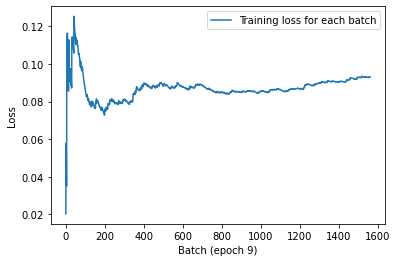

In [41]:
model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=10, callbacks=callbacks, validation_data=(val_images, val_labels))

### Monitoring and visualization with TensorBoard

In [42]:
model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

tensorboard = TensorBoard(log_dir="./")
model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2984 - accuracy: 0.9114 - val_loss: 0.1571 - val_accuracy: 0.9565
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1669 - accuracy: 0.9543 - val_loss: 0.1278 - val_accuracy: 0.9672
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1410 - accuracy: 0.9626 - val_loss: 0.1108 - val_accuracy: 0.9718
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1232 - accuracy: 0.9680 - val_loss: 0.1133 - val_accuracy: 0.9720
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1187 - accuracy: 0.9707 - val_loss: 0.1104 - val_accuracy: 0.9757
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1120 - accuracy: 0.9730 - val_loss: 0.1178 - val_accuracy: 0.9756
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1049 - accuracy: 0.9759 - val_loss: 0.1073 - val_accuracy:

In [45]:
%load_ext tensorboard
%tensorboard --logdir ./

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2408), started 22:41:37 ago. (Use '!kill 2408' to kill it.)